<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Importing libraries</h1>

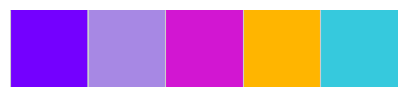

In [18]:
import warnings

import matplotlib.pyplot as plt
import missingno as mn
import numpy as np
import pandas as pd
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot
from tqdm import tqdm

init_notebook_mode(connected=True)
import seaborn as sns
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn import metrics
from sklearn.model_selection import (
    KFold,
    RepeatedKFold,
    RepeatedStratifiedKFold,
    StratifiedKFold,
)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

pd.set_option("display.max_columns", 50)
warnings.filterwarnings("ignore")
# warnings.filterwarnings("ignore", category="FutureWarning")
# warnings.filterwarnings("ignore", category="DeprecationWarning")
# warnings.filterwarnings("ignore", category="UserWarning")

# Color Palette
custom_colors = ["#7400ff", "#a788e4", "#d216d2", "#ffb500", "#36c9dd"]
sns.palplot(sns.color_palette(custom_colors))

# Set Style
sns.set_style("darkgrid")
sns.despine(left=True, bottom=True)

# Set tick size
plt.rc("xtick", labelsize=12)
plt.rc("ytick", labelsize=12)

<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Reading the files with Pandas</h1>

In [2]:
train = pd.read_csv("train.csv").drop("id", axis=1)
test = pd.read_csv("test.csv").drop("id", axis=1)
ss = pd.read_csv("sample_submission.csv")

In [3]:
train.head()

,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class
0,133.171875,59.716081,0.043133,-0.703383,54.917224,70.084438,0.749798,-0.649512,0
1,87.093750,36.257973,0.435469,2.266057,3.417224,21.865069,7.039330,52.686251,0
2,112.640625,39.818393,0.379639,0.922306,2.730769,15.689690,8.193471,85.649785,0
3,120.679688,45.918448,-0.098490,0.011775,2.696488,20.954662,8.183874,70.332899,0
4,134.070312,57.720107,-0.107772,-0.573335,1.107860,11.255051,16.107748,308.753765,0


In [4]:
test.head()

,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve
0,140.046875,54.507800,0.058862,-0.567263,2.337793,14.868335,9.591760,117.988781
1,107.828125,51.578965,0.284368,-0.338430,1.574415,12.501437,11.694968,182.704822
2,135.062500,49.812343,-0.087784,-0.094341,3.576923,21.243336,7.252386,59.021499
3,112.812500,41.926647,0.519921,1.287762,6.669732,29.013153,5.097661,27.105240
4,96.210938,35.322620,0.481286,2.443080,2.218227,17.041064,9.766006,117.131775


In [5]:
ss.head()

,id,Class
0,117564,0.5
1,117565,0.5
2,117566,0.5
3,117567,0.5
4,117568,0.5


<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Looking at the distribution of the data</h1>


<Figure size 640x480 with 0 Axes>

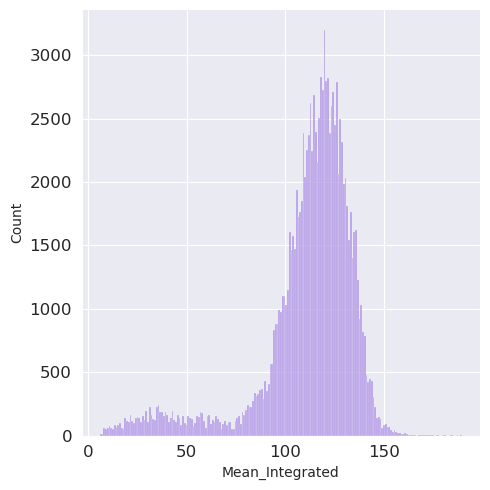

<Figure size 640x480 with 0 Axes>

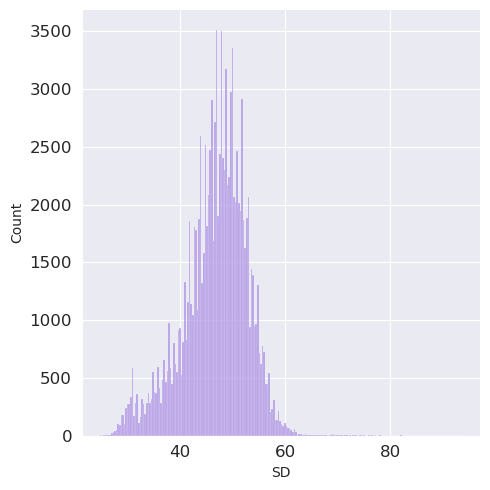

<Figure size 640x480 with 0 Axes>

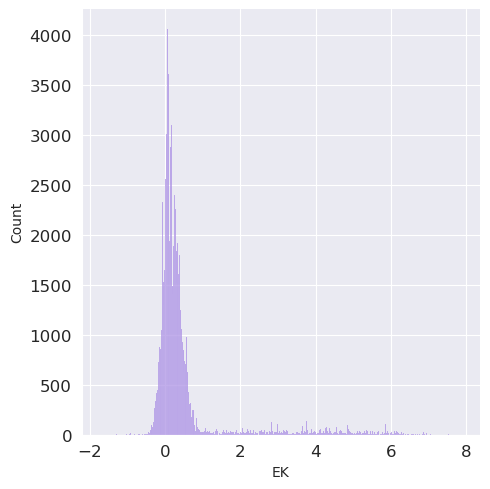

<Figure size 640x480 with 0 Axes>

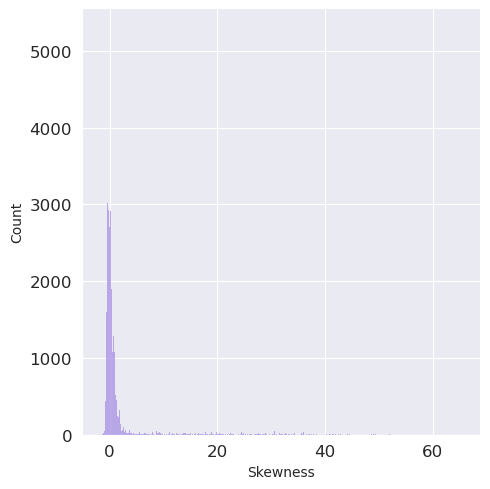

<Figure size 640x480 with 0 Axes>

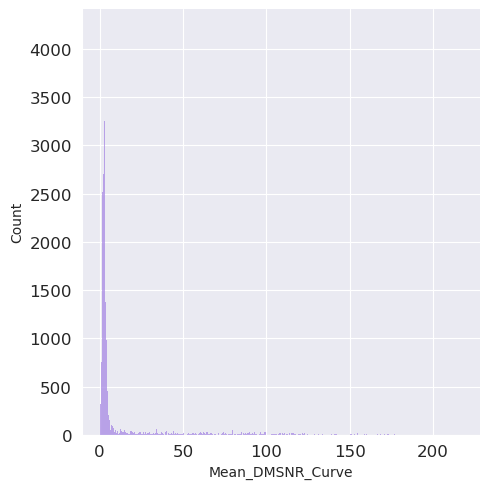

<Figure size 640x480 with 0 Axes>

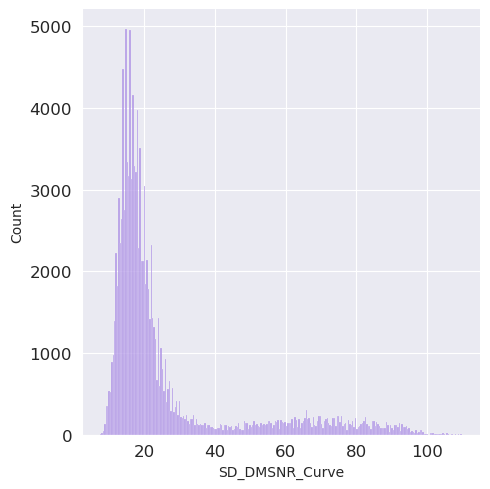

<Figure size 640x480 with 0 Axes>

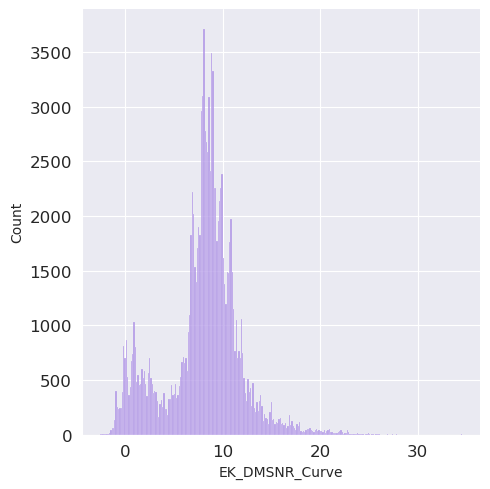

<Figure size 640x480 with 0 Axes>

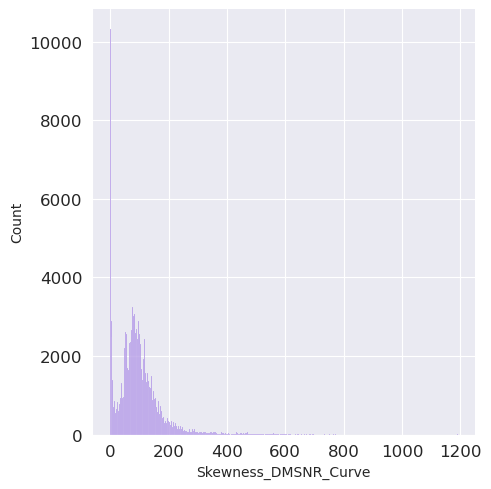

<Figure size 640x480 with 0 Axes>

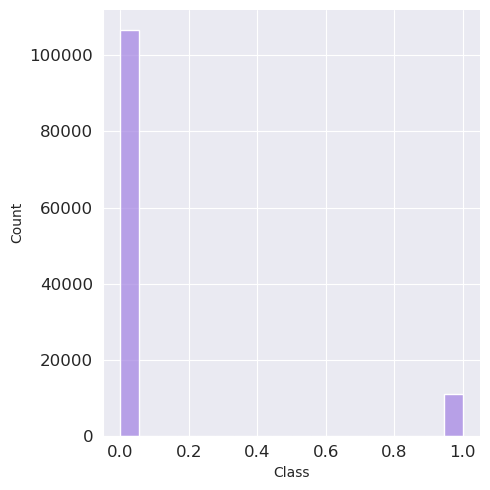

In [22]:
## Distributions of all numerical features
# Use a for loop to create a distribution for each feature
for feature in train.columns.to_list():
    plt.figure()
    sns.displot(
        x=feature,
        data=train,
        color=custom_colors[1],
    )
    plt.show()

<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Selection of X and y variables</h1>

In [7]:
X = train.drop("Class", 1)
y = train["Class"]

<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Training the model with Catboost Classifier</h1>

In [8]:
%%time
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=55)

preds = []
scores = []
feature_importance_df = pd.DataFrame()

for fold, (idx_train, idx_valid) in enumerate(kf.split(X, y)):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    model = CatBoostClassifier(
        use_best_model=True, verbose=0, bootstrap_type="Bayesian"
    )
    # model = LGBMClassifier(**params)

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=False,
        early_stopping_rounds=100,
    )

    pred_valid = model.predict_proba(X_valid)[:, 1]
    fpr, tpr, _ = metrics.roc_curve(y_valid, pred_valid)
    score = metrics.auc(fpr, tpr)
    scores.append(score)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = X.columns
    fold_importance_df["importance"] = model.feature_importances_
    fold_importance_df["fold"] = fold + 1
    feature_importance_df = pd.concat(
        [feature_importance_df, fold_importance_df], axis=0
    )

    print(f"Fold: {fold + 1} Score: {score}" "\n")
    print("||" * 40, "\n")

    test_preds = model.predict_proba(test)[:, 1]
    preds.append(test_preds)

print(f"Overall Validation Score: {np.mean(scores)}")

Fold: 1 Score: 0.9945020617375377

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 2 Score: 0.9961105761748312

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 3 Score: 0.9952226864671002

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 4 Score: 0.9958556595593303

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 5 Score: 0.9970000924391614

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 6 Score: 0.9959263431067775

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 7 Score: 0.9972999205707948

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 8 Score: 0.9968557049422117

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 9 Score: 0.9953482119056116

|||||||||||||||||||||

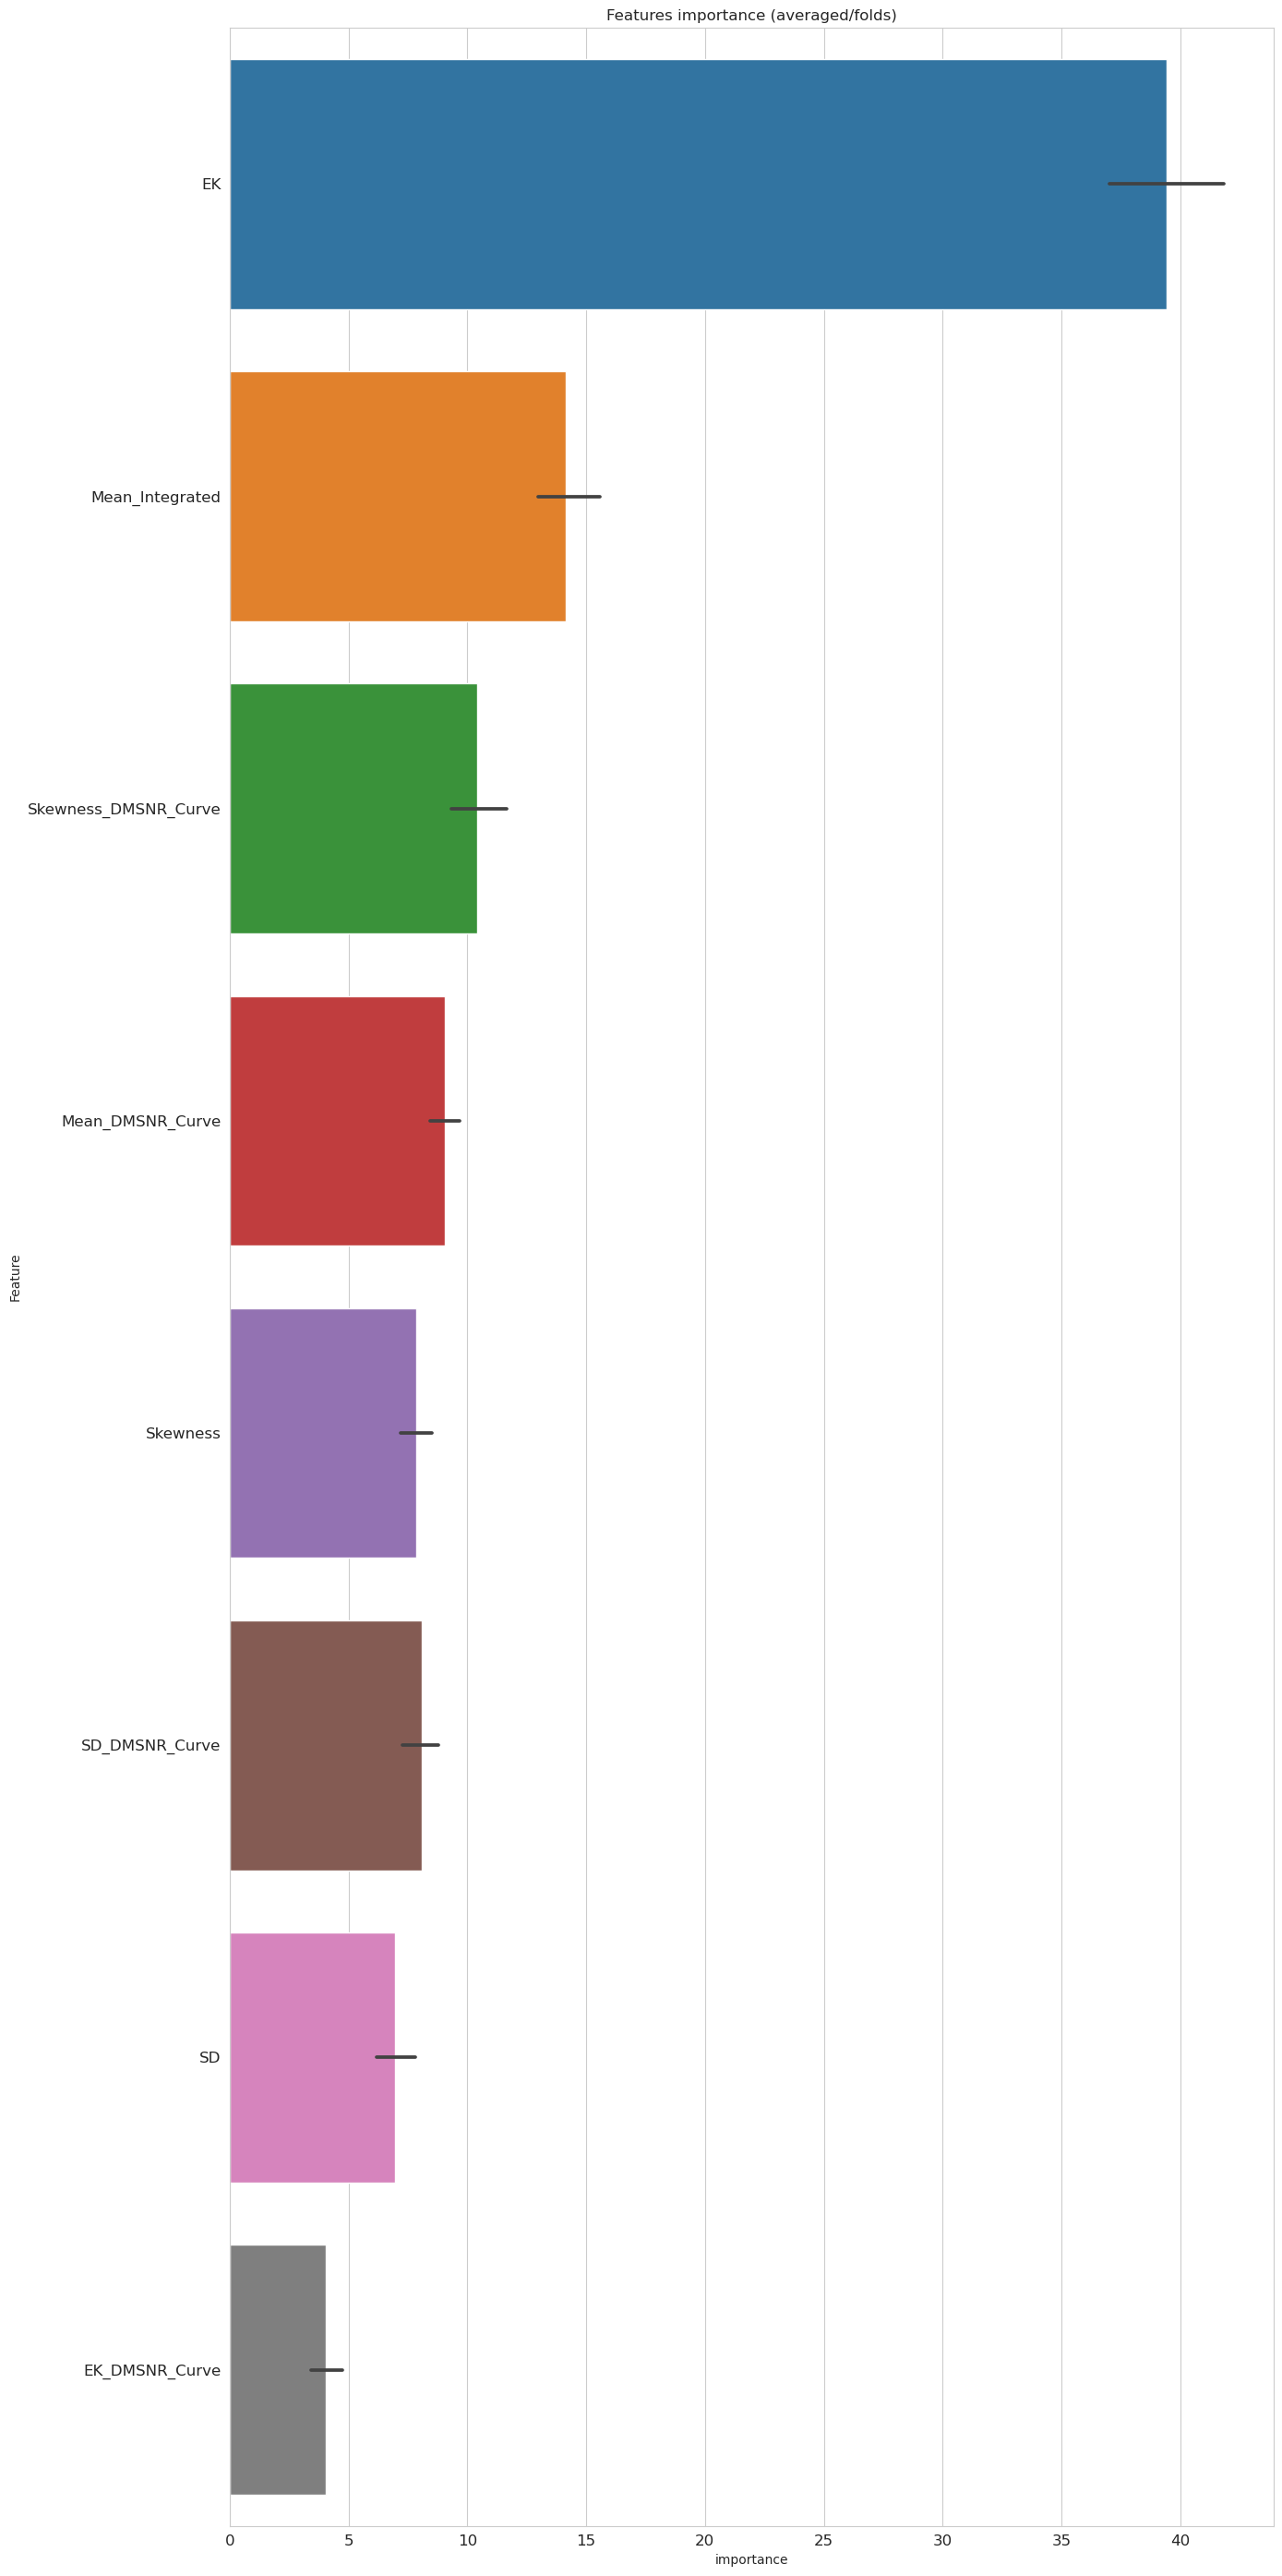

In [9]:
cols = (
    feature_importance_df[["Feature", "importance"]]
    .groupby("Feature")
    .mean()
    .sort_values(by="importance", ascending=False)[:107]
    .index
)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14, 28))
sns.barplot(
    x="importance",
    y="Feature",
    data=best_features.sort_values(
        by="importance",
        ascending=False,
    ),
)
plt.title("Features importance (averaged/folds)")
plt.tight_layout()
# plt.savefig("FI.png")

<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Making the submission file</h1>

In [10]:
predictions = np.mean(np.column_stack(preds), axis=1)

ss["Class"] = predictions
ss.to_csv("./cb.csv", index=False)
ss.head()

,id,Class
0,117564,0.000042
1,117565,0.000742
2,117566,0.000142
3,117567,0.067225
4,117568,0.002699


<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Training another model with LightGBM Classifier</h1>

# LightGBM


In [12]:
%%time
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=55)

preds = []
scores = []
feature_importance_df = pd.DataFrame()

for fold, (idx_train, idx_valid) in enumerate(kf.split(X, y)):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    # model = CatBoostClassifier(
    #     use_best_model=True, verbose=0, bootstrap_type="Bayesian"
    # )
    model = LGBMClassifier(objective="binary", class_weight="balanced")

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=False,
        early_stopping_rounds=100,
    )

    pred_valid = model.predict_proba(X_valid)[:, 1]
    fpr, tpr, _ = metrics.roc_curve(y_valid, pred_valid)
    score = metrics.auc(fpr, tpr)
    scores.append(score)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = X.columns
    fold_importance_df["importance"] = model.feature_importances_
    fold_importance_df["fold"] = fold + 1
    feature_importance_df = pd.concat(
        [feature_importance_df, fold_importance_df], axis=0
    )

    print(f"Fold: {fold + 1} Score: {score}" "\n")
    print("||" * 40, "\n")

    test_preds = model.predict_proba(test)[:, 1]
    preds.append(test_preds)

print(f"Overall Validation Score: {np.mean(scores)}")

Fold: 1 Score: 0.9943098694888499

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 2 Score: 0.9956049331196629

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 3 Score: 0.994671635588104

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 4 Score: 0.9958327846198313

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 5 Score: 0.996323360745539

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 6 Score: 0.9961848731871653

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 7 Score: 0.9970957412936005

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 8 Score: 0.9962380236319012

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 9 Score: 0.9952645288094346

|||||||||||||||||||||||

In [13]:
predictions = np.mean(np.column_stack(preds), axis=1)

ss["Class"] = predictions
ss.to_csv("./lgb.csv", index=False)
ss.head()

,id,Class
0,117564,0.000276
1,117565,0.004861
2,117566,0.000656
3,117567,0.391571
4,117568,0.008794
